In [52]:
import pandas as pd
import pandas.core.series
import numpy as np
from scipy.stats import kurtosis, skew, chi2, probplot
import matplotlib.pyplot as plt

df = pd.read_csv('../datasets/students_simple.csv')

N = 23
cols = df.columns.tolist()
col1 = cols[N % 5]
col2 = cols[(N**2) % 5 + 5]
print(col1, col2)

data1 = df[col1].dropna()
data2 = df[col2].dropna()

df.head()

iq test_time


,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


In [53]:
# общая функция для анализа выборки
def analyze_data(col, data: pd.core.series.Series, name='data', plot_hist=False, bins=15):
    """Вычисляет базовые статистики, рисует гистограмму, Q-Q plot, считает χ2"""
    res = {}
    # 1. Характеристики
    mean_ = data.mean()  # среднее
    var_ = data.var(ddof=1)  # дисперсия
    mode_ = data.mode()  # мода
    if len(mode_) > 0:
        mode_ = mode_.iloc[0]
    else:
        mode_ = np.nan
    median_ = data.median()
    q25, q50, q75 = data.quantile([0.25,0.5,0.75])
    kurt_ = kurtosis(data, fisher=True)  # эксцесс
    skew_ = skew(data)  # асимметрия
    iqr_ = q75 - q25  # интерквартильный размах

    res.update({
        'mean': mean_,
        'var': var_,
        'mode': mode_,
        'median': median_,
        'q25': q25,
        'q50': q50,
        'q75': q75,
        'kurt': kurt_,
        'skew': skew_,
        'iqr': iqr_
    })

    print(f"\n--- {name} ---")
    print(f"  Среднее: {mean_:.3f}")
    print(f"  Дисперсия: {var_:.3f}")
    print(f"  Мода: {mode_}")
    print(f"  Медиана: {median_:.3f}")
    print(f"  Квантили 0.25/0.5/0.75: {q25:.3f}, {q50:.3f}, {q75:.3f}")
    print(f"  Эксцесс: {kurt_:.3f}")
    print(f"  Асимметрия: {skew_:.3f}")
    print(f"  Интерквартильный размах: {iqr_:.3f}")
    if plot_hist:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Гистограмма
        axes[0].hist(data, bins=bins, edgecolor='black', alpha=0.7)
        axes[0].set_title(f'Гистограмма: {name}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Частота')

        # Эмпирическая функция распределения
        data_sorted = np.sort(data)
        y = np.arange(1, len(data_sorted)+1) / len(data_sorted)
        axes[1].step(data_sorted, y, where='post')
        axes[1].set_title(f'ECDF: {name}')
        axes[1].set_xlabel(col)
        axes[1].set_ylabel('F(x)')

        plt.tight_layout()
        plt.show()

    # x2 тест
    def sturges_rule(n): return int(np.round(1 + np.log2(n)))
    def normal_pdf(z): return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)
    def grouped_series(values):
        k = sturges_rule(len(values))
        x_min, x_max = values.min(), values.max()
        boundaries = np.linspace(x_min, x_max, k + 1)
        obs_counts, _ = np.histogram(values, bins=boundaries)
        centers = (boundaries[:-1] + boundaries[1:]) / 2
        return obs_counts, centers, boundaries
    def expected_normal_freq(left, right, mean, std, observed, centers):
        k = len(observed)
        h = (right - left) / k
        total = observed.sum()
        expected = []
        for c in centers:
            prob = h / std * normal_pdf((c - mean) / std)
            expected.append(total * prob)
        return np.array(expected)
    def chi_square_statistic(obs, exp):
        exp = np.where(exp < 1e-8, 1e-8, exp)  # защита от деления на 0
        return np.sum((obs - exp) ** 2 / exp)

    # obs, mid_points, bounds = grouped_series(data)
    # exp = expected_normal_freq(bounds[0], bounds[-1], mean_, data.std(ddof=1), obs, mid_points)
    # chi2_value = chi_square_statistic(obs, exp)
    # degrees_freedom = len(obs) - 1 - 2
    # alpha = 0.05
    # chi2_threshold = chi2.ppf(1 - alpha, degrees_freedom)
    # print(f"χ² = {chi2_value:.2f}; крит. знач. = {chi2_threshold:.2f} (df={degrees_freedom})")
    # if chi2_value > chi2_threshold:
    #     print("❌ Гипотеза нормальности ОТКЛОНЯЕТСЯ (χ² > крит)")
    #     res['normtest'] = False
    # else:
    #     print("✅ Нет оснований отклонять гипотезу нормальности (χ² <= крит)")
    #     res['normtest'] = True

    # Q-Q plot
    # probplot(data, dist='norm', plot=plt)
    # plt.title(f'Q-Q plot: {name}')
    # plt.show()

    return res


--- iq ---
  Среднее: 107.400
  Дисперсия: 88.253
  Мода: 104
  Медиана: 105.500
  Квантили 0.25/0.5/0.75: 101.500, 105.500, 112.000
  Эксцесс: -0.394
  Асимметрия: 0.460
  Интерквартильный размах: 10.500


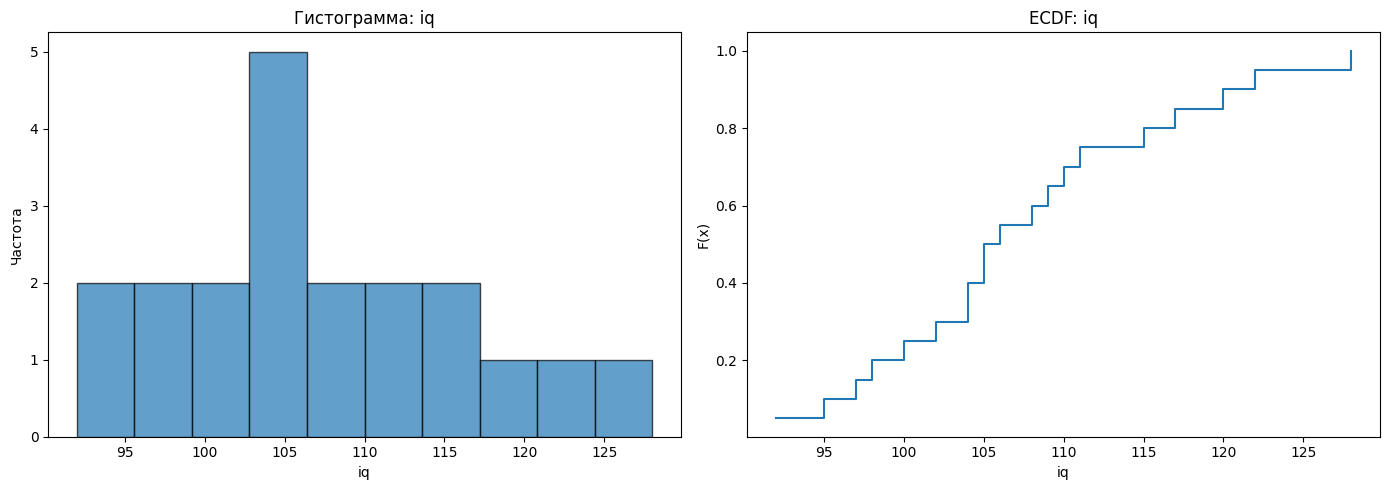

In [54]:
_ = analyze_data(col1, data1, name=col1, plot_hist=True, bins=10)


--- test_time ---
  Среднее: 7.730
  Дисперсия: 6.365
  Мода: 10.0
  Медиана: 7.650
  Квантили 0.25/0.5/0.75: 6.150, 7.650, 9.625
  Эксцесс: -0.746
  Асимметрия: 0.160
  Интерквартильный размах: 3.475


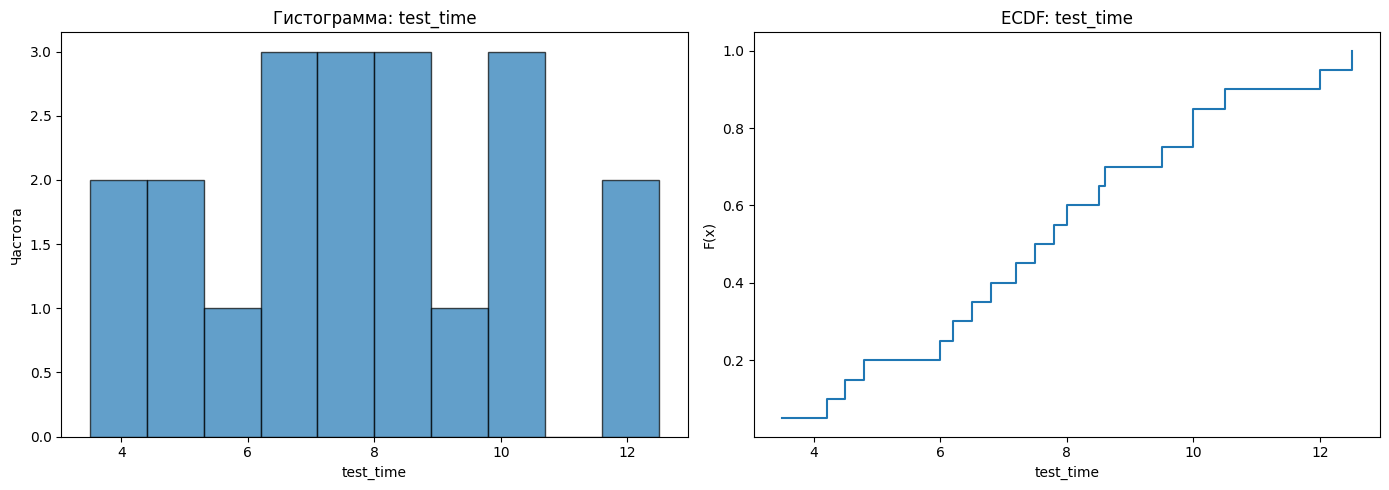

In [55]:
_ = analyze_data(col2, data2, name=col2, plot_hist=True, bins=10)

Выборка слишком небольшая, чтобы подтверждать связь гистограммы с нормальным распределением. Но в целом отклонений от нормальности не слишком много у обоих распределений.

## 1. Расчет корреляций


In [56]:
x = data1.values
y = data2.values
n = min(len(x), len(y))

# Корреляция Фехнера
x_mean = np.mean(x)
y_mean = np.mean(y)

sign_x = np.sign(x - x_mean)
sign_y = np.sign(y - y_mean)

same_sign = np.sum(sign_x == sign_y)
diff_sign = np.sum(sign_x != sign_y)

K_fechner = (same_sign - diff_sign) / n

# Корреляция Пирсона
cov_xy = np.sum((x - x_mean) * (y - y_mean)) / (n - 1)
Sx = np.sqrt(np.sum((x - x_mean)**2) / (n - 1))
Sy = np.sqrt(np.sum((y - y_mean)**2) / (n - 1))
K_pearson = cov_xy / (Sx * Sy)

T = K_pearson * np.sqrt(n - 2) / np.sqrt(1 - K_pearson**2)

# Корреляция Спирмена
R_x = pd.Series(x).rank().values
R_y = pd.Series(y).rank().values
d = R_x - R_y
K_spearman = 1 - (6 * np.sum(d**2)) / (n * (n - 1) * (n + 1))

# Корреляция Кенделла
concordant = 0
discordant = 0
for i in range(n - 1):
    for j in range(i + 1, n):
        concordant += (x[i] < x[j]) == (y[i] < y[j])
        discordant += (x[i] < x[j]) != (y[i] < y[j])

K_kendall = 1 - 4 * discordant / (n * (n - 1))

print(f"Число наблюдений: n = {n}\n")
print(f"Корреляция Фехнера: {K_fechner:.4f}")
print(f"Корреляция Пирсона: {K_pearson:.4f}")
print(f"Корреляция Спирмена: {K_spearman:.4f}")
print(f"Корреляция Кенделла: {K_kendall:.4f}")


Число наблюдений: n = 20

Корреляция Фехнера: -0.7000
Корреляция Пирсона: -0.6818
Корреляция Спирмена: -0.6805
Корреляция Кенделла: -0.5158


* Фехнера: -0.7000 -> сильная обратная зависимость между параметрами.
* Пирсона: -0.6818 -> линейная зависимость отрицательная.
* Спирмена: -0.6805 -> ранговая корреляция также указывает на обратную зависимость.
* Кенделла: -0.5158 -> подтверждает умеренную отрицательную зависимость.

Вывод: все методы показывают обратную зависимость: чем выше iq, тем меньше test_time (время прохождения теста?).

## 2. График рассеяния (scatter plot)

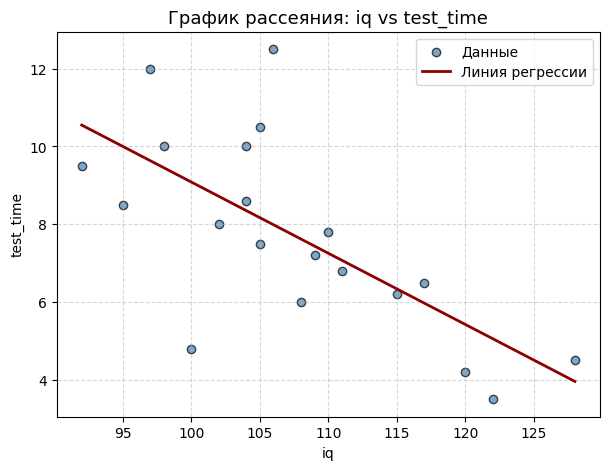

In [57]:
plt.figure(figsize=(7, 5))
plt.scatter(x, y, color='steelblue', alpha=0.7, edgecolors='k', label='Данные')

# линия регрессии (y=a+b*x)
b = np.cov(x, y, ddof=1)[0, 1] / np.var(x, ddof=1)
a = np.mean(y) - b * np.mean(x)
x_line = np.linspace(min(x), max(x), 100)
y_line = a + b * x_line
plt.plot(x_line, y_line, color='darkred', linewidth=2, label='Линия регрессии')

plt.title(f'График рассеяния: {col1} vs {col2}', fontsize=13)
plt.xlabel(col1)
plt.ylabel(col2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.show()


На графике рассеяния заметна отрицательная линейная тенденция между iq и test_time

Вывод: визуально подтверждается обратная связь между показателями

## 3. Уравнение регрессии

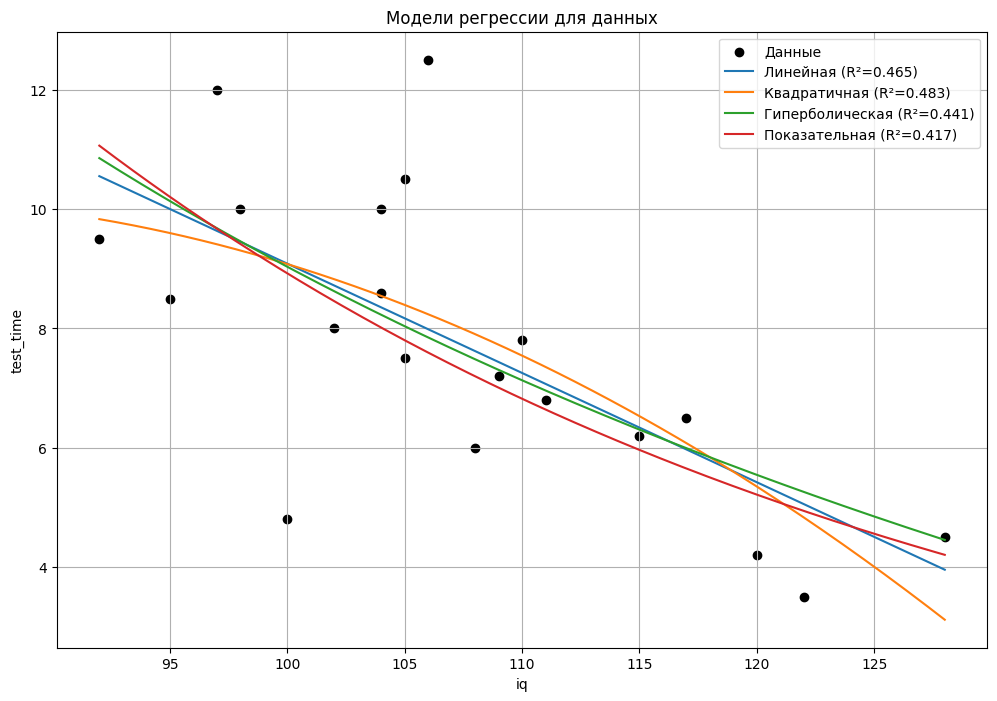

,Модель,Параметры,R²,RMSE,MAE
0,Линейная,"w1=-0.1831, w0=27.3961",0.4649,1.7989,1.3269
1,Квадратичная,"w2=-0.0033, w1=0.5396, w0=-11.8827",0.4825,1.7690,1.3223
2,Гиперболическая,"w1=2091.8740, w0=-11.8859",0.4410,1.8386,1.3337
3,Показательная,"w0=130.8014, w1=0.9735",0.4174,1.8769,1.3798


In [58]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

x = np.array(data1.values)
y = np.array(data2.values)
n = len(x)

# сетка для графиков
x_plot = np.linspace(min(x), max(x), 200)

plt.figure(figsize=(12, 8))
plt.scatter(x, y, label='Данные', color='black')

results = []  # результаты для таблицы

# 1. Линейная модель: y = w1*x + w0
A_lin = np.vstack([x, np.ones(len(x))]).T
w_lin, _, _, _ = np.linalg.lstsq(A_lin, y, rcond=None)
y_pred_lin = w_lin[0]*x + w_lin[1]
y_plot_lin = w_lin[0]*x_plot + w_lin[1]
r2_lin = r2_score(y, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y, y_pred_lin))
mae_lin = mean_absolute_error(y, y_pred_lin)
plt.plot(x_plot, y_plot_lin, label=f'Линейная (R²={r2_lin:.3f})')
results.append(['Линейная',
                f'w1={w_lin[0]:.4f}, w0={w_lin[1]:.4f}',
                r2_lin, rmse_lin, mae_lin])

# 2. Квадратичная модель: y = w2*x^2 + w1*x + w0
A_quad = np.vstack([x**2, x, np.ones(len(x))]).T
w_quad, _, _, _ = np.linalg.lstsq(A_quad, y, rcond=None)
y_pred_quad = w_quad[0]*x**2 + w_quad[1]*x + w_quad[2]
y_plot_quad = w_quad[0]*x_plot**2 + w_quad[1]*x_plot + w_quad[2]
r2_quad = r2_score(y, y_pred_quad)
rmse_quad = np.sqrt(mean_squared_error(y, y_pred_quad))
mae_quad = mean_absolute_error(y, y_pred_quad)
plt.plot(x_plot, y_plot_quad, label=f'Квадратичная (R²={r2_quad:.3f})')
results.append(['Квадратичная',
                f'w2={w_quad[0]:.4f}, w1={w_quad[1]:.4f}, w0={w_quad[2]:.4f}',
                r2_quad, rmse_quad, mae_quad])

# 3. Гиперболическая модель: y = w1/x + w0
A_hyp = np.vstack([1/x, np.ones(len(x))]).T
w_hyp, _, _, _ = np.linalg.lstsq(A_hyp, y, rcond=None)
y_pred_hyp = w_hyp[0]/x + w_hyp[1]
y_plot_hyp = w_hyp[0]/x_plot + w_hyp[1]
r2_hyp = r2_score(y, y_pred_hyp)
rmse_hyp = np.sqrt(mean_squared_error(y, y_pred_hyp))
mae_hyp = mean_absolute_error(y, y_pred_hyp)
plt.plot(x_plot, y_plot_hyp, label=f'Гиперболическая (R²={r2_hyp:.3f})')
results.append(['Гиперболическая',
                f'w1={w_hyp[0]:.4f}, w0={w_hyp[1]:.4f}',
                r2_hyp, rmse_hyp, mae_hyp])

# 4. Показательная модель: y = w0 * w1^x
# преобразуем ln(y) = ln(w0) + x*ln(w1)
mask = y > 0  # логарифм только положительных
x_exp = x[mask]
y_exp = y[mask]
A_exp = np.vstack([x_exp, np.ones(len(x_exp))]).T
lny = np.log(y_exp)
w_exp, _, _, _ = np.linalg.lstsq(A_exp, lny, rcond=None)
a = np.exp(w_exp[1])
b = np.exp(w_exp[0])
y_pred_exp = a * b**x_exp
y_plot_exp = a * b**x_plot
r2_exp = r2_score(y_exp, y_pred_exp)
rmse_exp = np.sqrt(mean_squared_error(y_exp, y_pred_exp))
mae_exp = mean_absolute_error(y_exp, y_pred_exp)
plt.plot(x_plot, y_plot_exp, label=f'Показательная (R²={r2_exp:.3f})')
results.append(['Показательная',
                f'w0={a:.4f}, w1={b:.4f}',
                r2_exp, rmse_exp, mae_exp])

plt.title('Модели регрессии для данных')
plt.xlabel(col1)
plt.ylabel(col2)
plt.legend()
plt.grid(True)
plt.show()

# Таблица сравнения
df_results = pd.DataFrame(results, columns=['Модель', 'Параметры', 'R²', 'RMSE', 'MAE'])
display(df_results.style.format({'R²': '{:.4f}', 'RMSE': '{:.4f}', 'MAE': '{:.4f}'}))


Лучшая модель по R²: квадратичная

Худшая модель по R²: показательная

Вывод: квадратичная модель лучше всего описывает зависимость test_time от iq

## 4. Проверка значимости регрессии с помощью критерия Фишера

In [59]:
from scipy.stats import f

# лучшая модель: квадратичная
y_pred_best = w_quad[0]*x**2 + w_quad[1]*x + w_quad[2]
k_best = 3  # число параметров (w2, w1, w0)
R2_best = r2_score(y, y_pred_best)

F_best = (R2_best / (1 - R2_best)) * ((n - k_best) / (k_best - 1))
p_value_best = 1 - f.cdf(F_best, dfn=k_best-1, dfd=n-k_best)

print("Лучшая модель (квадратичная)")
print(f"R² = {R2_best:.4f}")
print(f"Статистика F = {F_best:.4f}, p-value = {p_value_best:.4e}")
if p_value_best < 0.05:
    print("Регрессия значима на уровне 5%")
else:
    print("Регрессия не значима на уровне 5%")
print("\n")

# худшая модель: показательная
y_pred_worst = y_pred_exp  # вычислено ранее для всех x>0
k_worst = 2  # число параметров (w0, w1)
R2_worst = r2_score(y_exp, y_pred_worst)
n_exp = len(y_exp)

F_worst = (R2_worst / (1 - R2_worst)) * ((n_exp - k_worst) / (k_worst - 1))
p_value_worst = 1 - f.cdf(F_worst, dfn=k_worst-1, dfd=n_exp-k_worst)

print("Худшая модель (показательная)")
print(f"R² = {R2_worst:.4f}")
print(f"Статистика F = {F_worst:.4f}, p-value = {p_value_worst:.4e}")
if p_value_worst < 0.05:
    print("Регрессия значима на уровне 5%")
else:
    print("Регрессия не значима на уровне 5%")


Лучшая модель (квадратичная)
R² = 0.4825
Статистика F = 7.9258, p-value = 3.6991e-03
Регрессия значима на уровне 5%


Худшая модель (показательная)
R² = 0.4174
Статистика F = 12.8985, p-value = 2.0865e-03
Регрессия значима на уровне 5%


Вывод: все модели статистически значимы, но качество различается

Общие выводы:

1. Между iq и test_time наблюдается обратная зависимость.
2. Корреляционные методы согласуются между собой, обратная зависимость подтверждается.
3. Квадратичная регрессия лучше всего описывает данные, а показательная - наименее точная.
4. Статистическая проверка Фишера подтверждает значимость всех моделей.
